## Vertex functions

This code calculates the vertex functions from random-phase-approximation
of copolymer melts.

In [31]:
from Scalc import s2wlc, s2inverse, s4wlc
from itertools import product
import propagator 
import numpy as np

In [16]:
%matplotlib inline
import mpld3
import matplotlib.pyplot as plt
mpld3.enable_notebook()

## Quadratic vertex

In [17]:
def gamma2(pset, N, fa, K, CHI):
    s2inv = s2inverse(pset, N, fa, K)

    D = [1,-1]    # sign indicator
    G = 0
    for I0, I1 in product([0,1], repeat=2):
        G += s2inv[I0, I1]*D[I0]*D[I1]
        
    return -2*CHI + N*G

In [21]:
N=10
fa=0.5

nlam=4
pset=propagator.prop_set(nlam=nlam)

K = 10
CHI = 0

KV = np.logspace(-1,3,100)
gam2 = np.zeros((len(KV), 1),dtype=type(1+1j))

for i, K in enumerate(KV):
    gam2[i] = gamma2(pset, N, fa, K, CHI)

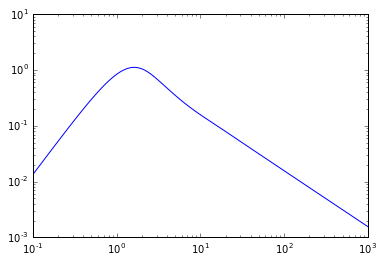

In [24]:
plt.loglog(KV, 1/gam2)
plt.show()

## Cubic Vertex

## Quartic Vertex

In [37]:
def gamma4(pset, N, fa, Ks):
    K1, K2, K3, K4 = Ks
    if np.linalg.norm(K1+K2+K3+K4) >= 1e-10:
        raise('Qs must add up to zero')
    
    K = np.linalg.norm(K1)
    K12 = np.linalg.norm(K1+K2)
    K13 = np.linalg.norm(K1+K3)
    K14 = np.linalg.norm(K1+K4)
    
    s4 = s4wlc(pset, N, fa, Ks)
    s31 = s3wlc(pset, N, fa, [K1, K2, -K1-K2])
    s32 = s3wlc(pset, N, fa, [K1, K3, -K1-K3])
    s33 = s3wlc(pset, N, fa, [K1, K4, -K1-K4])
    
    s2inv = s2inverse(pset, N, fa, K)
    s21inv = s2inverse(pset, N, fa, K12)
    s22inv = s2inverse(pset, N, fa, K13)
    s23inv = s2inverse(pset, N, fa, K14)
    
    D = [1,-1]    # sign indicator
    G4 = np.zeros((2,2,2,2),dtype=type(1+1j))
    for a1, a2, a3, a4 in product([0,1], repeat=4):
        for I0, I1 in product([0,1], repeat=2):
            G4[a1][a2][a3][a4] += \
                s31[a1][a2][I0]*s31[a3][a4][I1]*s21inv[I0][I1] + \
                s32[a1][a2][I0]*s32[a3][a4][I1]*s22inv[I0][I1] + \
                s33[a1][a2][I0]*s33[a3][a4][I1]*s23inv[I0][I1]
    G4 -= s4
    
    val = 0
    for I0, I1, I2, I3 in product([0,1], repeat=4):
        val += G4[I0][I1][I2][I3] *\
                (s2inv[I0][0] - s2inv[I0][1]) *\
                (s2inv[I1][0] - s2inv[I1][1]) *\
                (s2inv[I2][0] - s2inv[I2][1]) *\
                (s2inv[I3][0] - s2inv[I3][1])
                
    return val*(N**3)